In [1]:
import pickle

In [2]:
from pathlib import Path

In [3]:
import os
current = Path('.').resolve()
if current.name == 'notebooks':
    os.chdir('..')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import alphamoon

In [6]:
import alphamoon.constants

In [7]:
import numpy as np

In [8]:
import matplotlib.pyplot as plt

In [9]:
input_data_path = alphamoon.constants.RAW_DATA_DIR / 'train.pkl'
with input_data_path.open('rb') as file_handle:
    X_train, y_train = pickle.load(file_handle)

In [10]:
X_train.shape

(30134, 3136)

In [11]:
y_train.shape

(30134, 1)

In [12]:
count_arr = np.bincount(y_train[:,0])

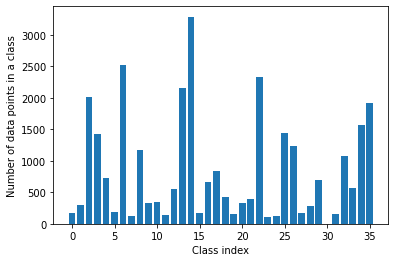

In [15]:
plt.bar(np.arange(len(count_arr)), count_arr)
plt.xlabel('Class index')
plt.ylabel('Number of data points in a class')
plt.savefig(alphamoon.constants.REPORTS_FIGURES_DIR / 'data_points_per_class.png', bbox_inches='tight', dpi=300)
plt.show()

Data set is unbalanced